In [142]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score

import plotly.express as px
import TsModel
import GprModel
from sklearn.utils import validation
from windrose import WindroseAxes
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [143]:
# Visualization for all models, used in the paper

In [144]:
plt.rcParams.update({'font.size': 18})

In [145]:
def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(30, activation=tf.keras.activations.tanh))    
    model.add(layers.Dense(1, activation=tf.keras.activations.relu))
    return model

In [237]:
train_x = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9x.csv', index_col=0).to_numpy()
train_y = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9y.csv', index_col=0)['0'].to_numpy().reshape(-1, 1)

test_x = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9x_test.csv', index_col=0).to_numpy()
test_y = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9y_test.csv', index_col=0)['0'].to_numpy().reshape(-1, 1)

In [ ]:
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

train_x, train_y = shuffle(train_x, train_y)

In [ ]:
linear_model = LinearRegression().fit(train_x, train_y)

In [ ]:
gpr_mdoel = GprModel.GprModel()

gpr_mdoel.fit(train_x, train_y)

[2.94203684 1.1344686  0.03390502]


In [ ]:
predicted_means,_ = gpr_mdoel.predict(test_x, test_y)

Root Mean Squared Error: 5.227306250618684


In [ ]:
np.array(predicted_means).ravel().shape

np.concatenate(predicted_means, axis=0).shape

(229000,)

In [ ]:
neural_network_model = build_neural_network_model()


neural_network_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]
)

history = neural_network_model.fit(
    train_x, 
    train_y, 
    epochs=50, 
    shuffle=True
)

Epoch 1/50
16697/16697 [==============================] - 33s 2ms/step - loss: 41.6051 - root_mean_squared_error: 6.4502 - mean_absolute_percentage_error: 46.4481
Epoch 2/50
16697/16697 [==============================] - 28s 2ms/step - loss: 31.2077 - root_mean_squared_error: 5.5864 - mean_absolute_percentage_error: 42.9671
Epoch 3/50
16697/16697 [==============================] - 28s 2ms/step - loss: 30.6509 - root_mean_squared_error: 5.5363 - mean_absolute_percentage_error: 42.5751
Epoch 4/50
16697/16697 [==============================] - 28s 2ms/step - loss: 30.3075 - root_mean_squared_error: 5.5052 - mean_absolute_percentage_error: 42.3420
Epoch 5/50
16697/16697 [==============================] - 28s 2ms/step - loss: 30.0972 - root_mean_squared_error: 5.4861 - mean_absolute_percentage_error: 42.1968
Epoch 6/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.9614 - root_mean_squared_error: 5.4737 - mean_absolute_percentage_error: 42.0900
Epoch 7/50
16697/16697

7157/7157 [==============================] - 5s 670us/step


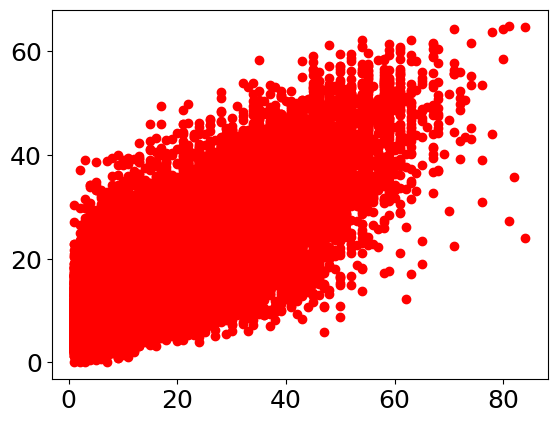

In [ ]:
pred = neural_network_model.predict(test_x)

plt.plot(test_y, pred, 'ro')

In [ ]:
# All stations in the dataset
stations_to_test = [
    'LETHBRIDGE CDA',                 
    'EDMONTON STONY PLAIN CS',        
    'CORONATION CLIMATE',             
    'STRATHMORE AGDM',                
    'LLOYDMINSTER',                  
    'MEDICINE HAT RCS',             
    'MILK RIVER',                     
    'CAMROSE',                     
    'BROOKS',                    
    'CLARESHOLM',           
    'ONEFOUR CDA',            
    'VEGREVILLE',             
    'ROCKY MTN HOUSE (AUT)',         
    'LACOMBE CDA 2',              
    'BANFF CS',                     
    'DRUMHELLER EAST',         
    'MEDICINE HAT',                 
    'LETHBRIDGE',                 
    'EDMONTON INTL A',         
    'CALGARY INTL A'
]

In [ ]:
def plot_prediction_error(y, y_prediction, station_name, axis_limit, axis):
    
    rmse = np.round(mean_squared_error(y, y_prediction, squared=False),4)

    axis.set_ylim(0,axis_limit)
    axis.set_xlim(0,axis_limit)
    axis.plot([0, axis_limit], [0, axis_limit], 'k--')
    axis.plot(y, y_prediction, 'ro', alpha=.2, label=f"RMSE for station = {rmse}")
    axis.legend(loc="upper left")
    axis.set_title(f"True v.s. predicted wind speed for \n {station_name}", wrap=True)

In [ ]:
def plot_side_by_side_prediction_error(y, nn_y_prediction, gpr_prediction, station_name):
    axis_limit = np.max(np.array(y).flatten())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10)) 
    
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    plot_prediction_error(y, nn_y_prediction, station_name +' neural network', axis_limit, ax1)
    plot_prediction_error(y, gpr_prediction, station_name +' GPR', axis_limit, ax2)    
    
    plt.show()

835/835 [==============================] - 1s 661us/step
Root Mean Squared Error: 5.560999879812254


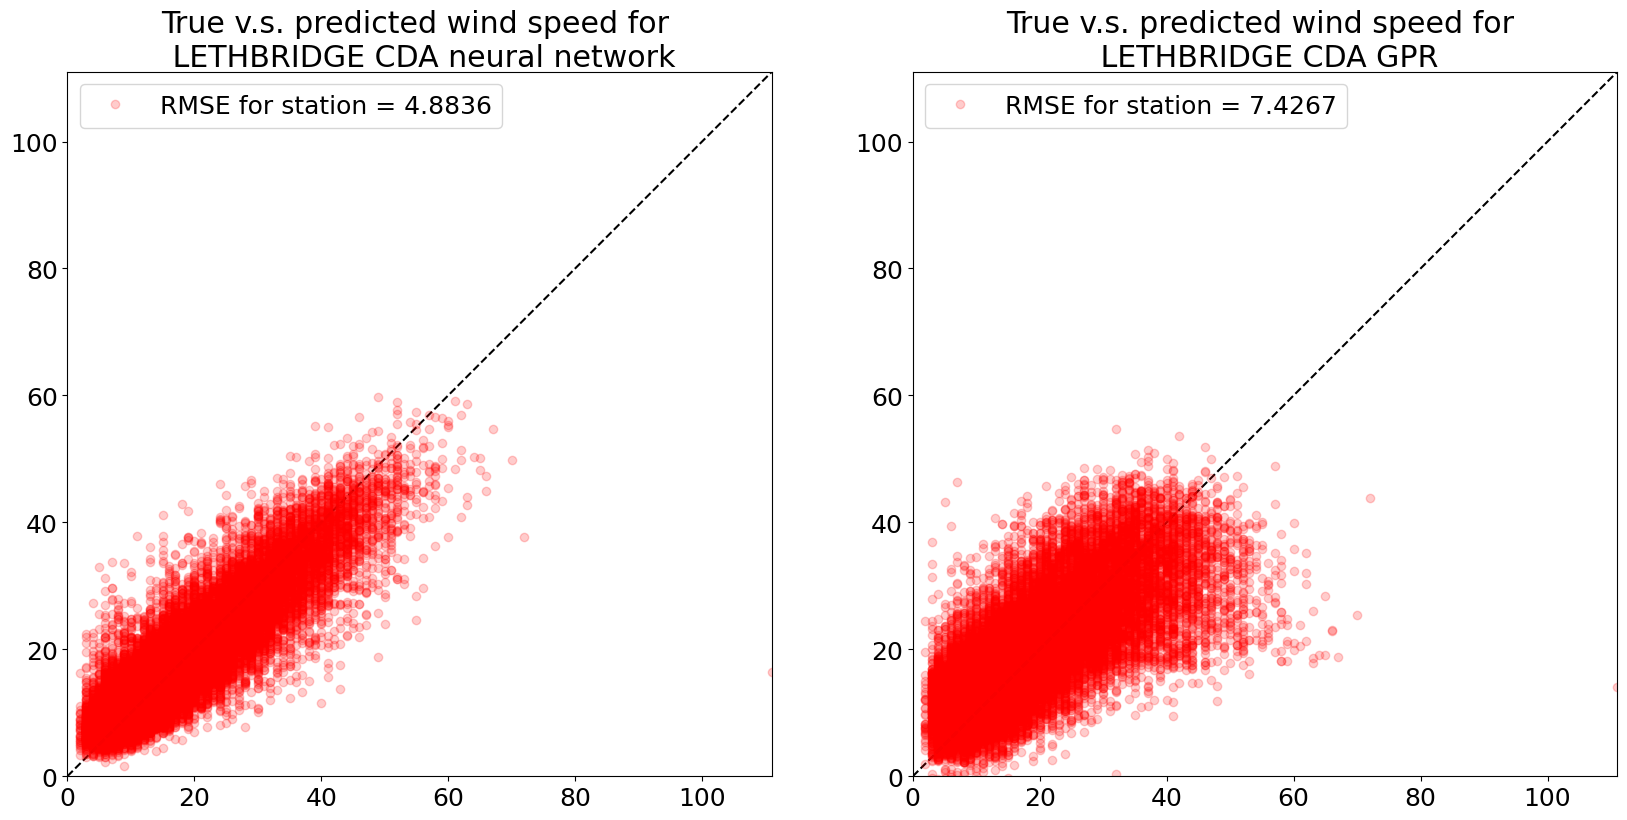

835/835 [==============================] - 1s 641us/step
Root Mean Squared Error: 3.560896830745151


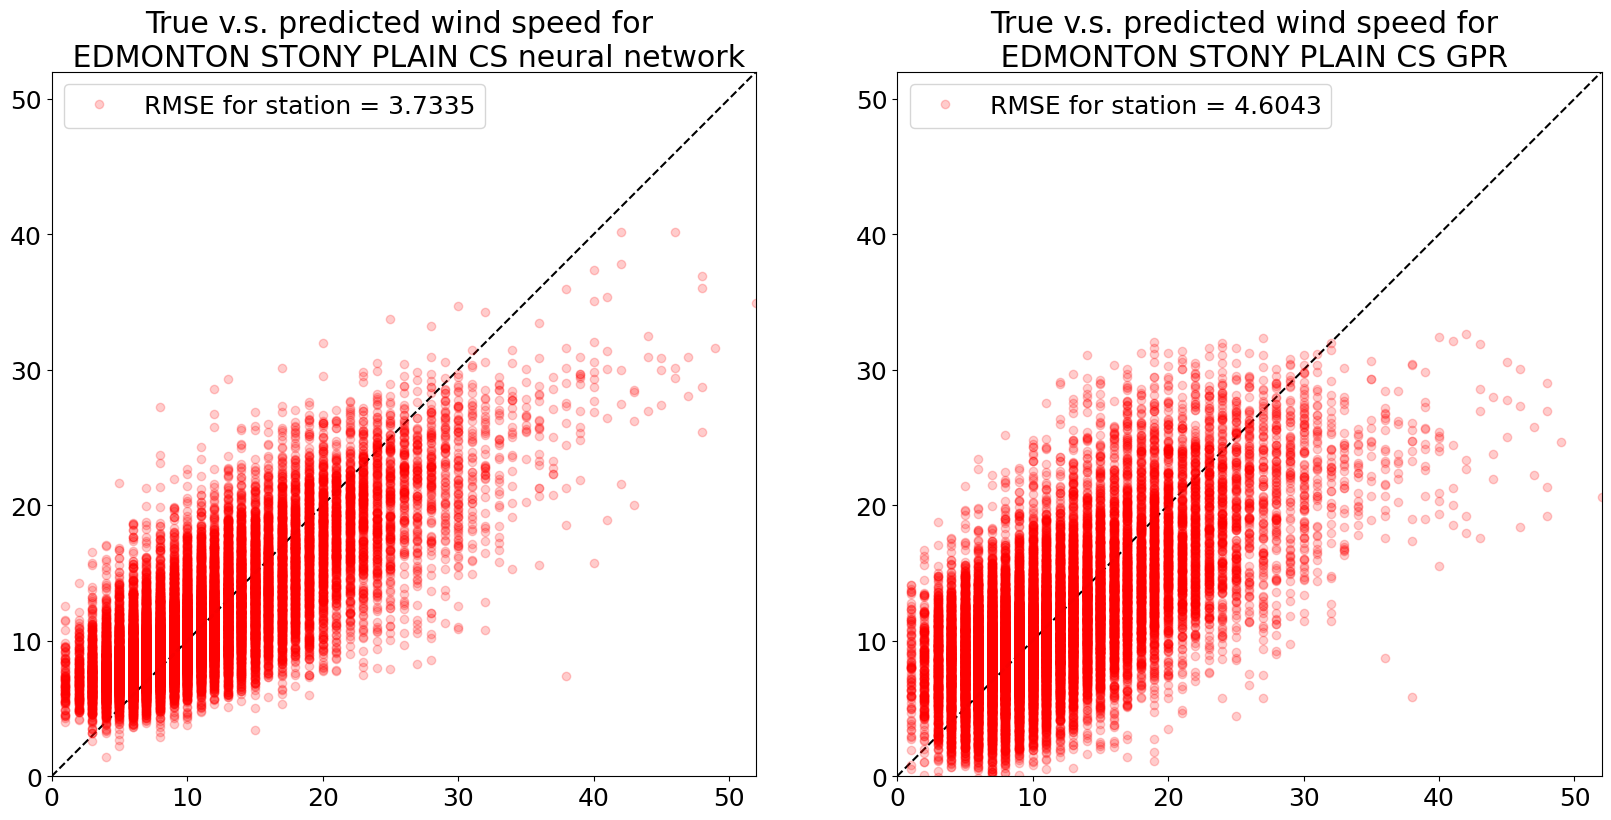

835/835 [==============================] - 1s 657us/step
Root Mean Squared Error: 5.370401462047432


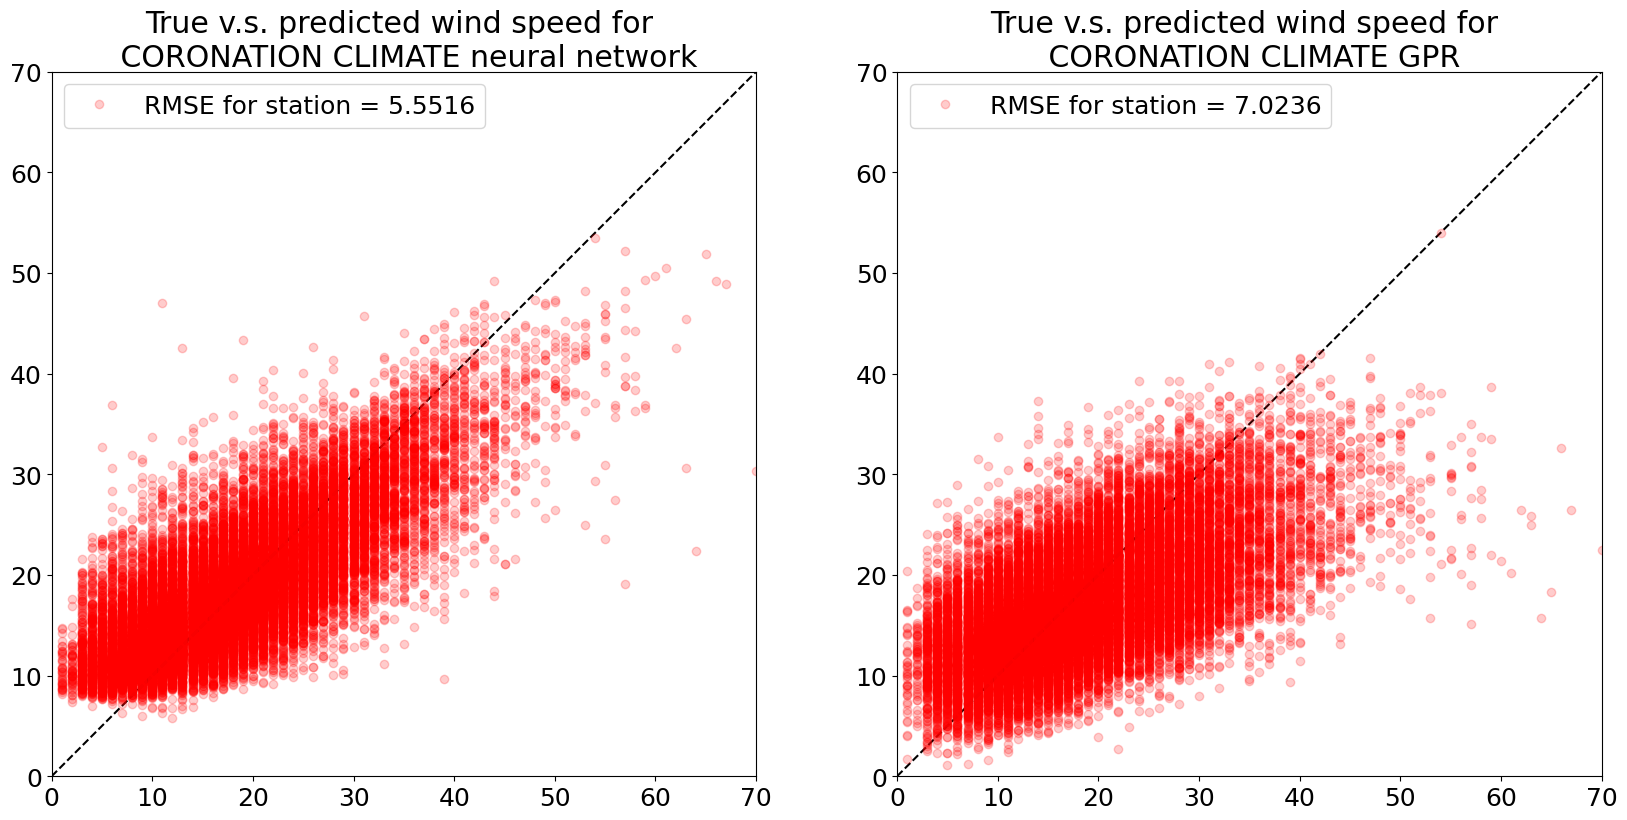

835/835 [==============================] - 1s 777us/step
Root Mean Squared Error: 5.245341369293099


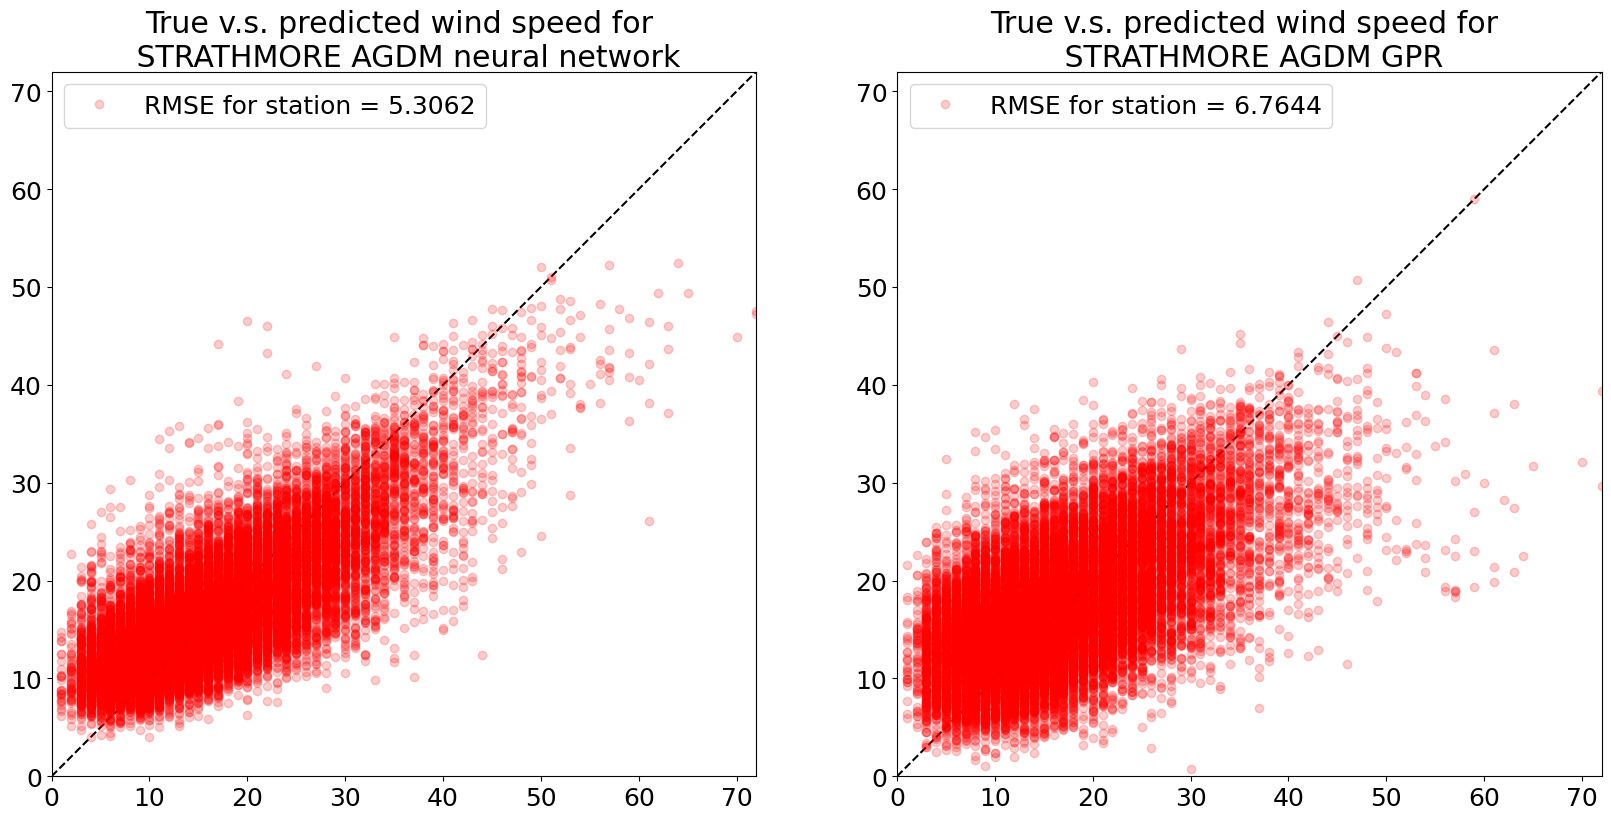

835/835 [==============================] - 1s 718us/step
Root Mean Squared Error: 5.860795637072199


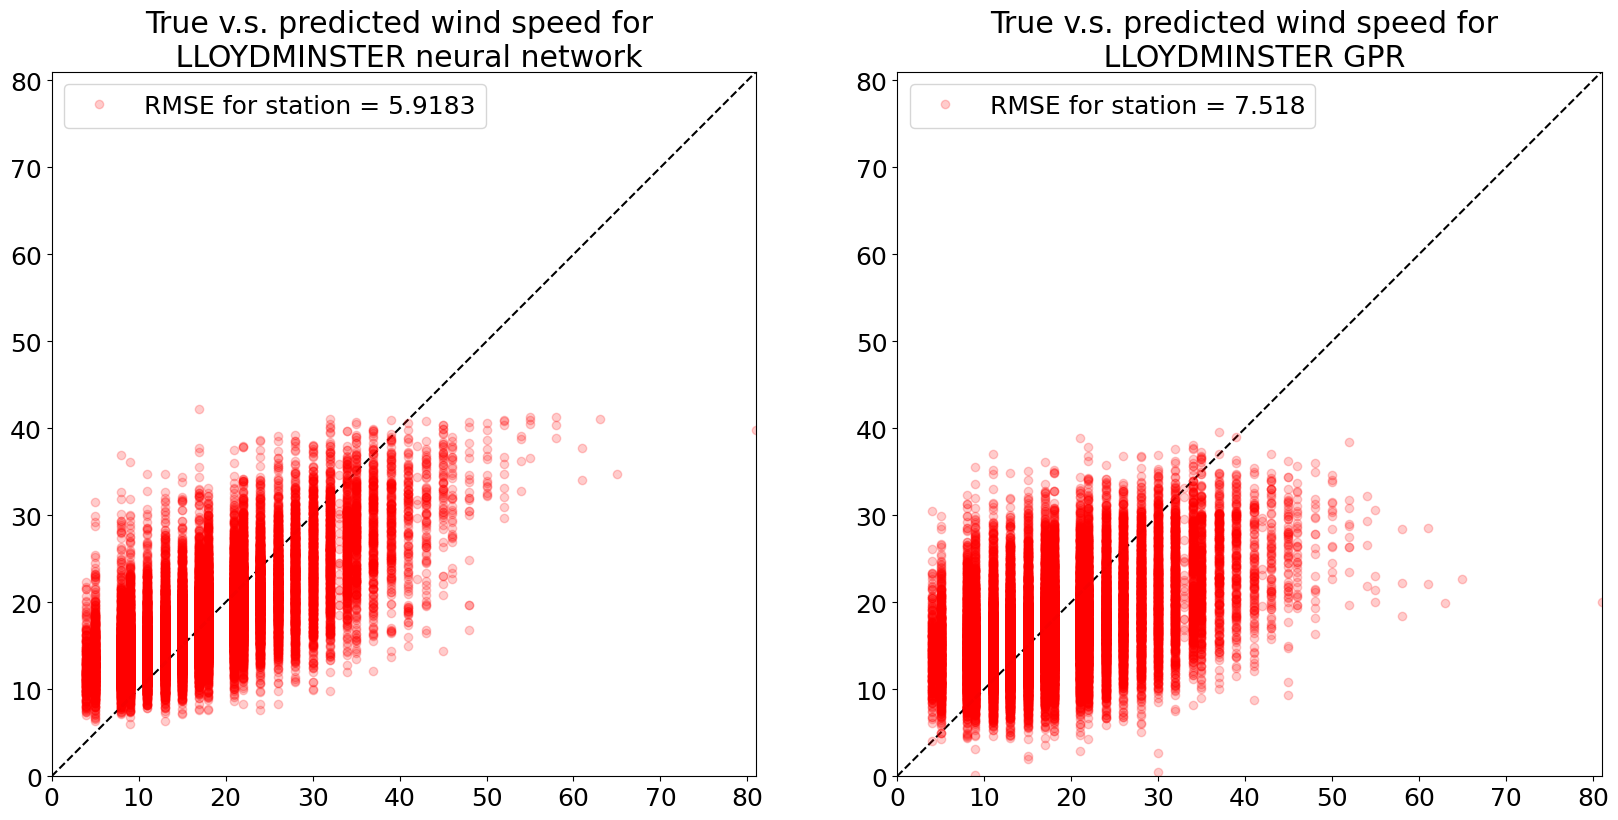

835/835 [==============================] - 1s 675us/step
Root Mean Squared Error: 4.41050185102432


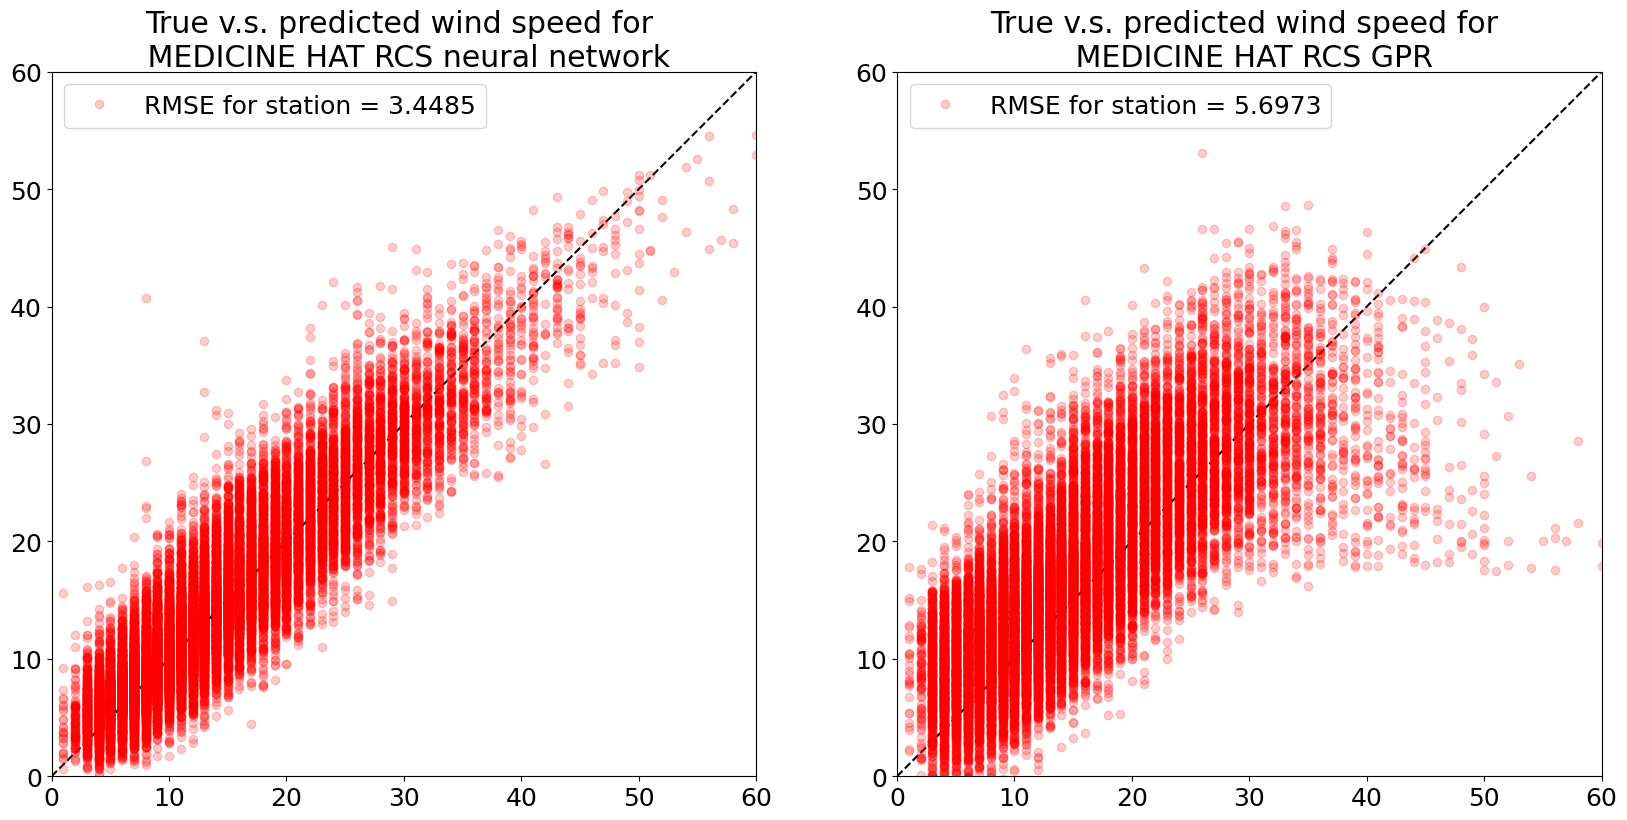

835/835 [==============================] - 1s 719us/step
Root Mean Squared Error: 6.967224935291383


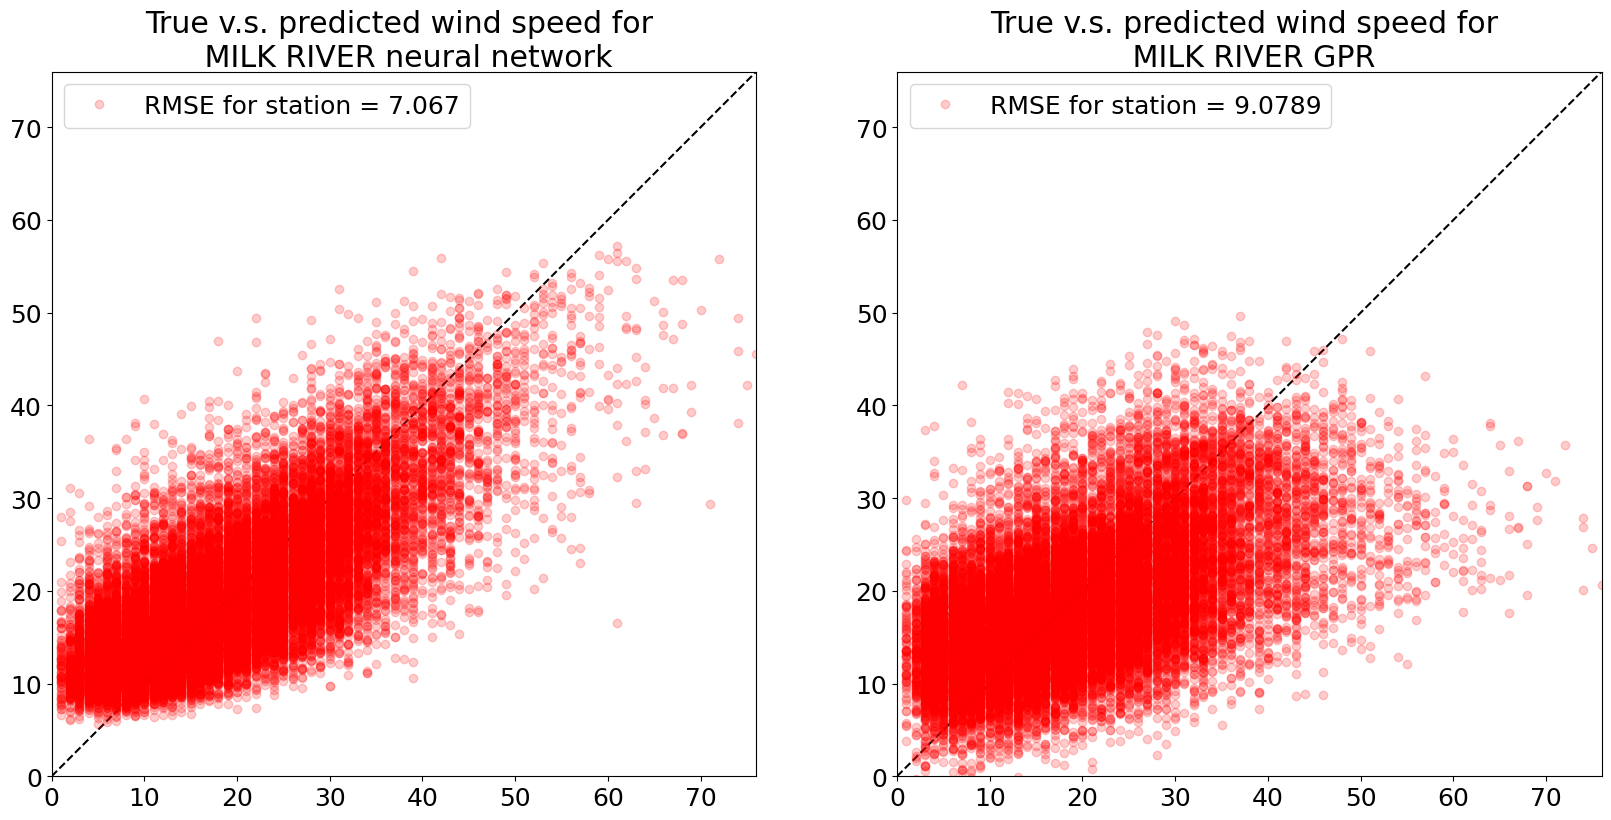

835/835 [==============================] - 1s 685us/step
Root Mean Squared Error: 4.106405545712952


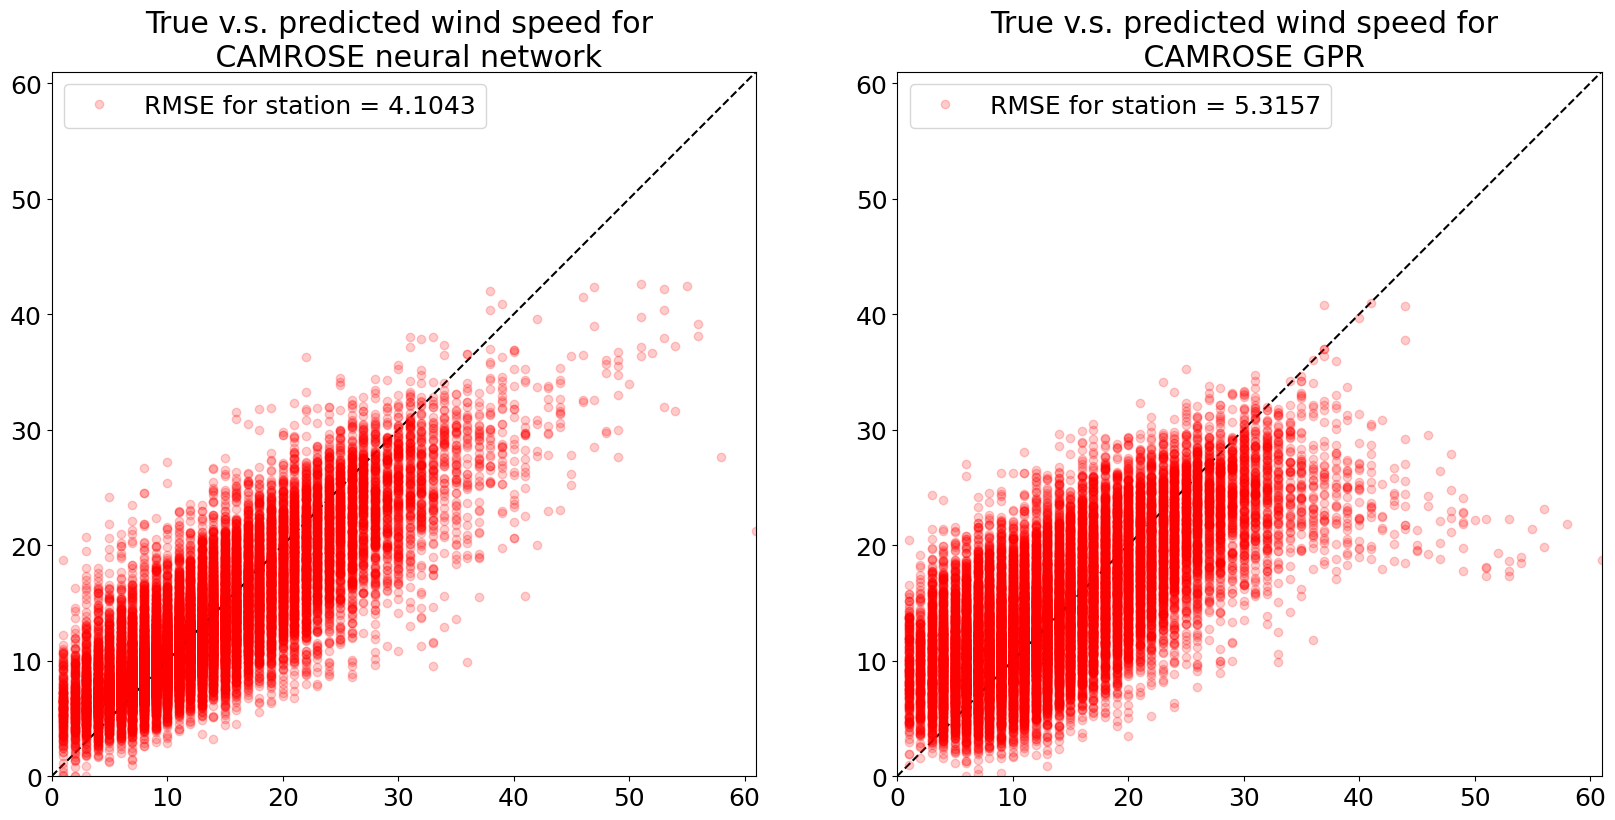

835/835 [==============================] - 1s 641us/step
Root Mean Squared Error: 4.820377196611775


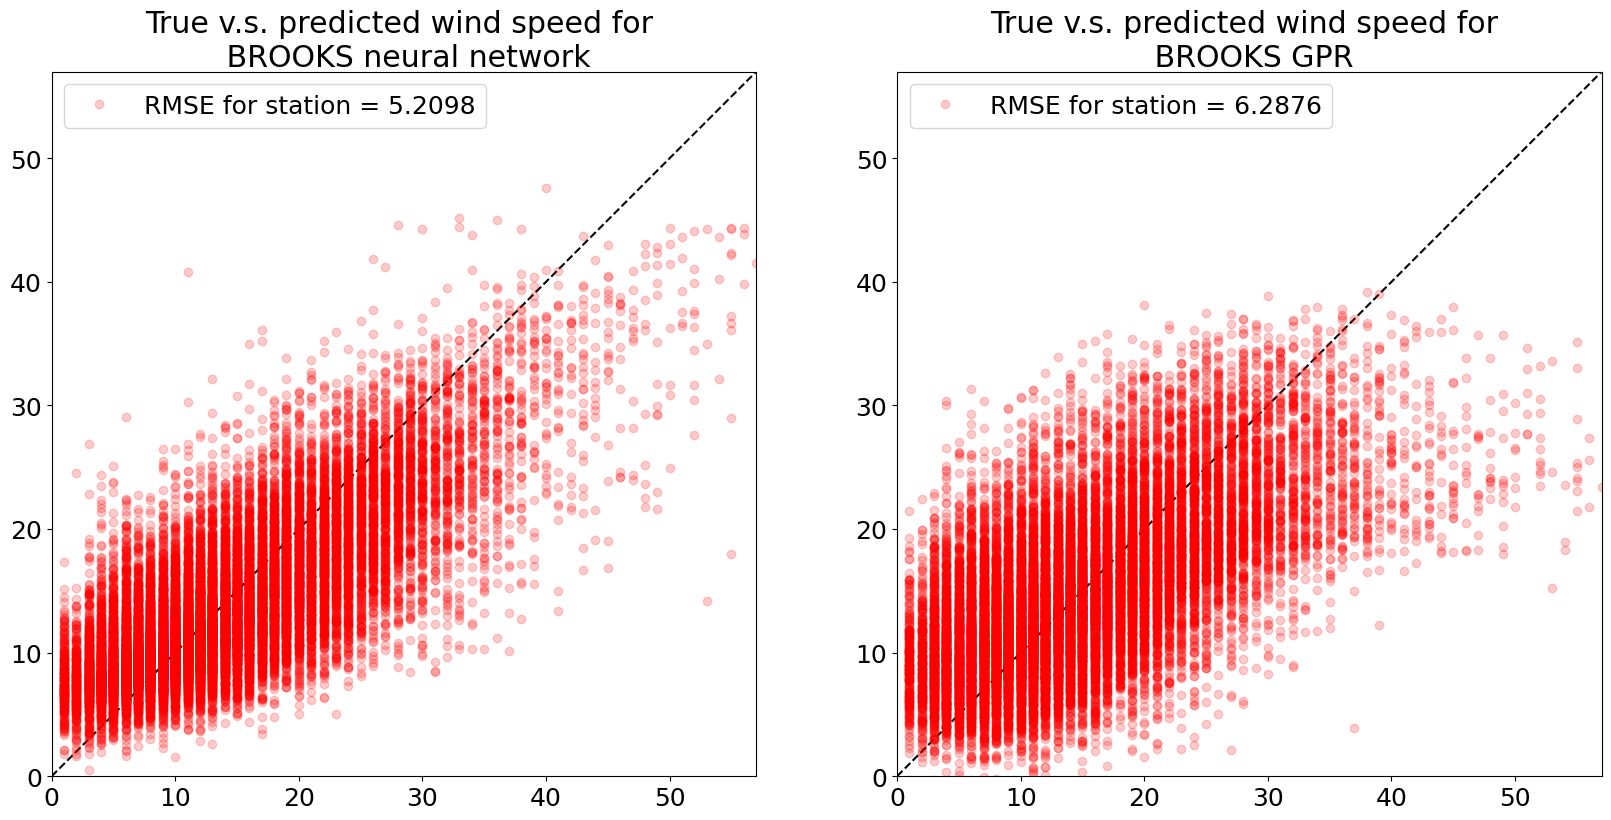

835/835 [==============================] - 1s 646us/step
Root Mean Squared Error: 6.370475787207285


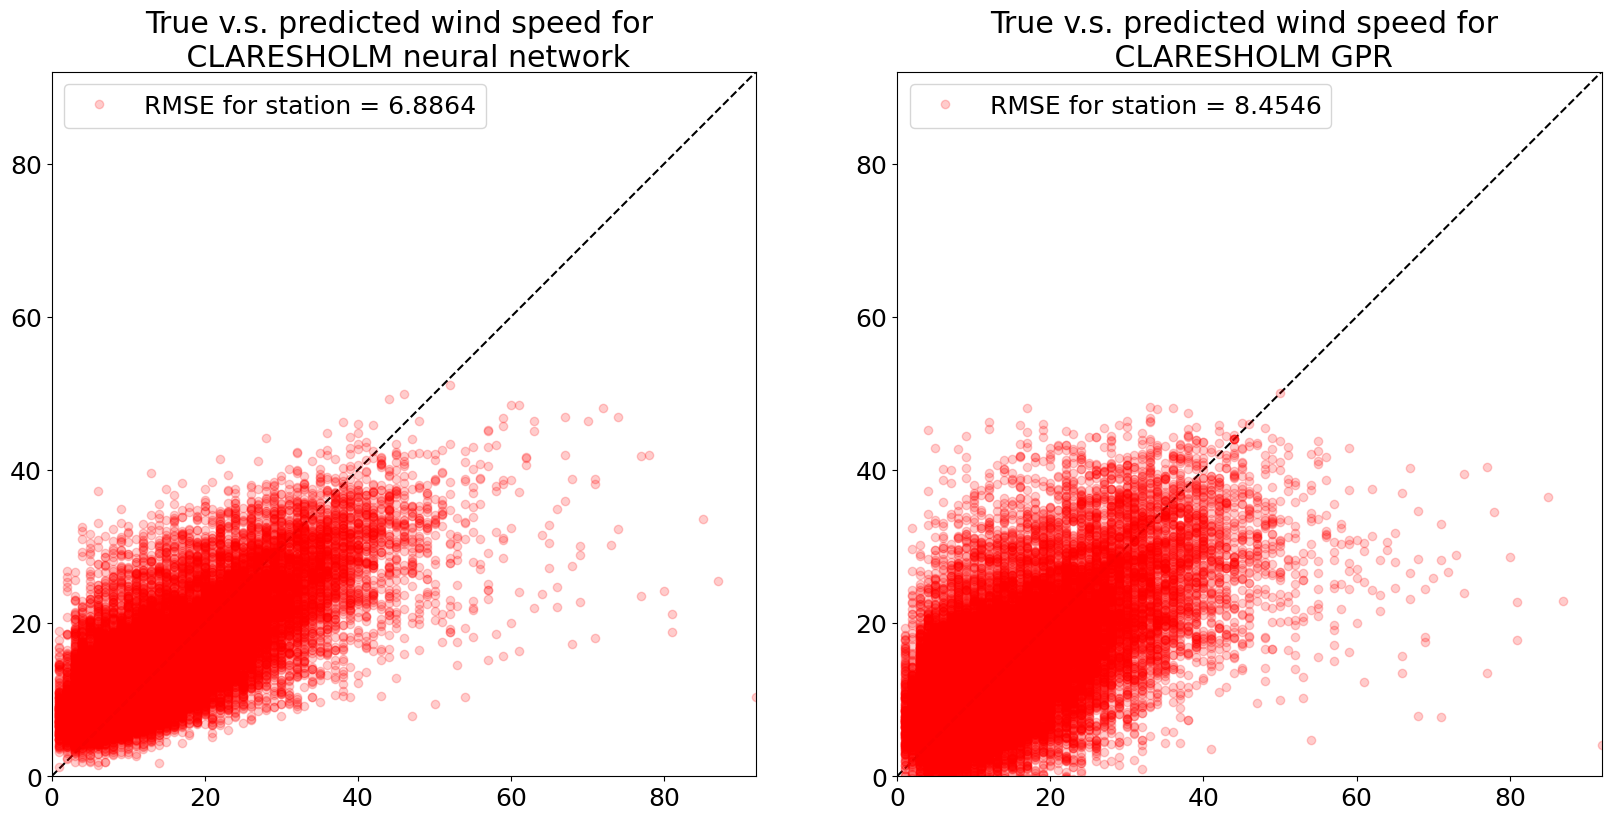

835/835 [==============================] - 1s 684us/step
Root Mean Squared Error: 7.786429418835627


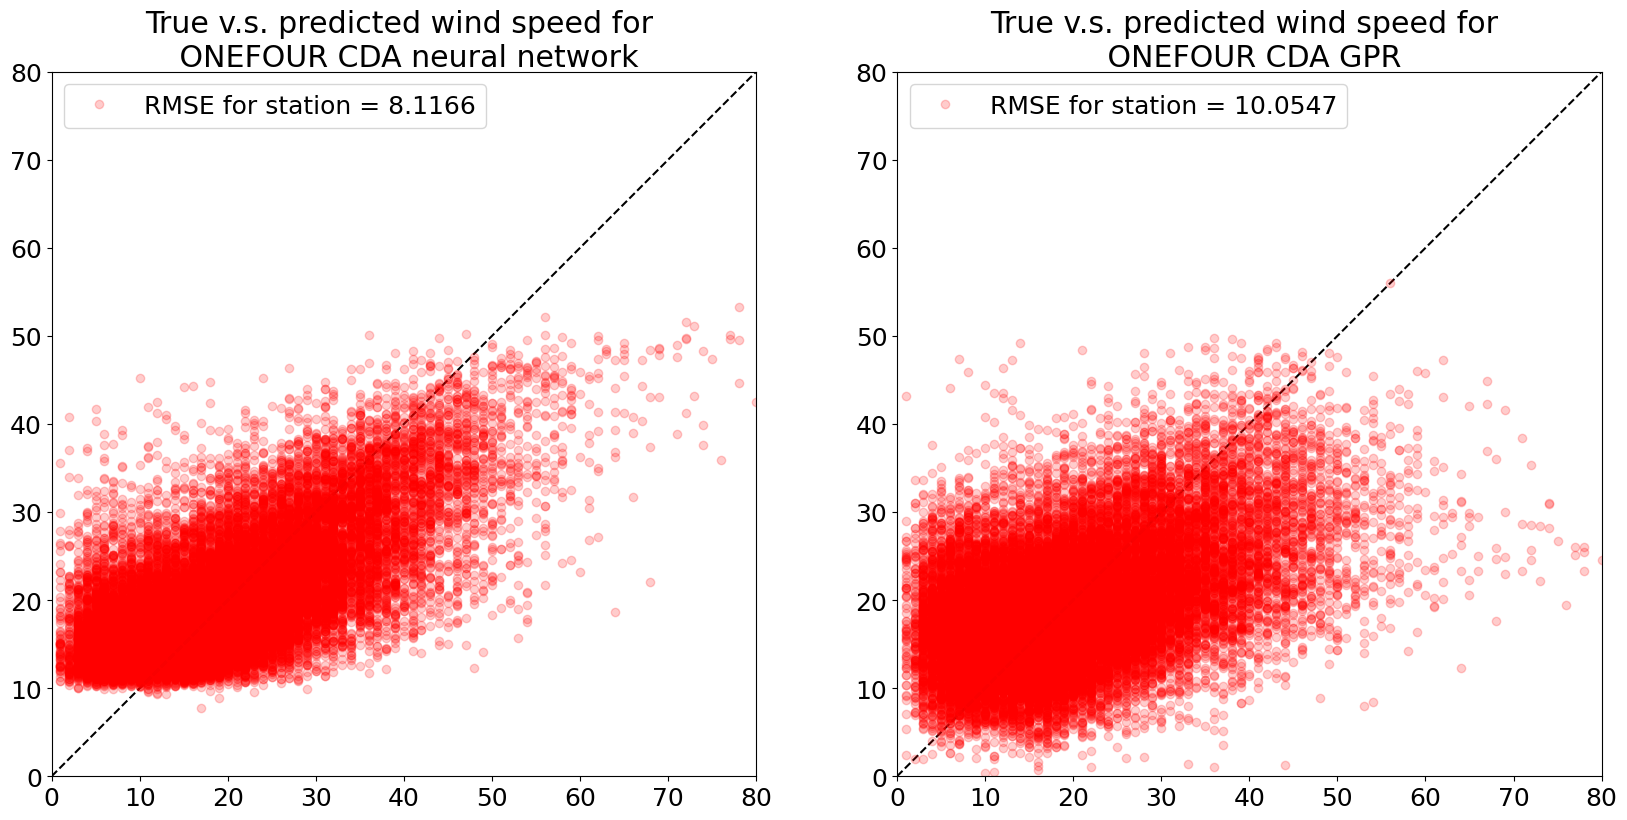

835/835 [==============================] - 1s 669us/step
Root Mean Squared Error: 4.272168461257165


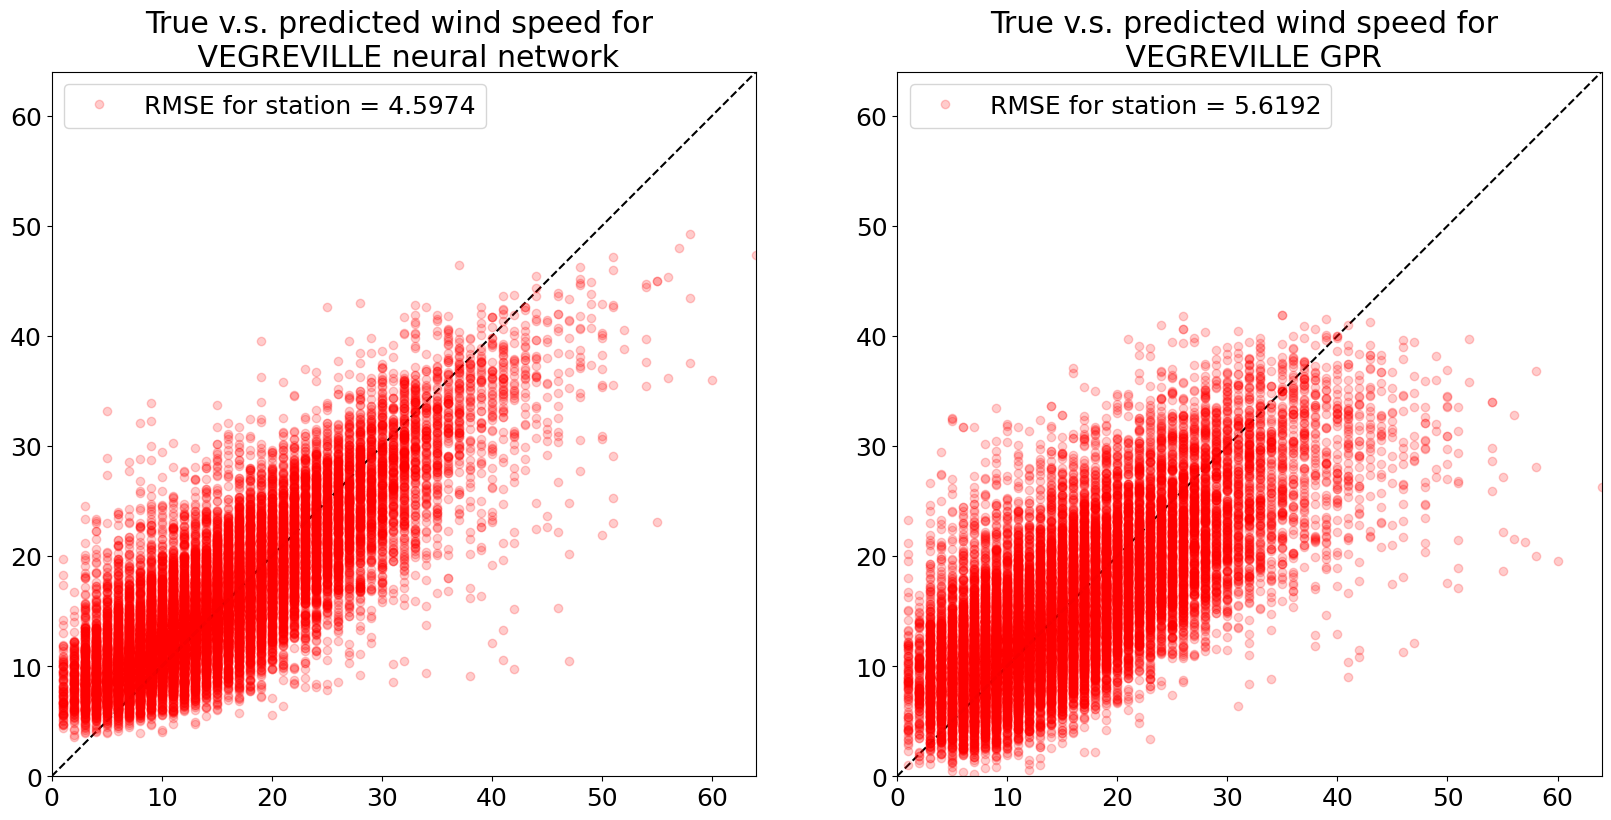

835/835 [==============================] - 1s 638us/step
Root Mean Squared Error: 4.6856395221874845


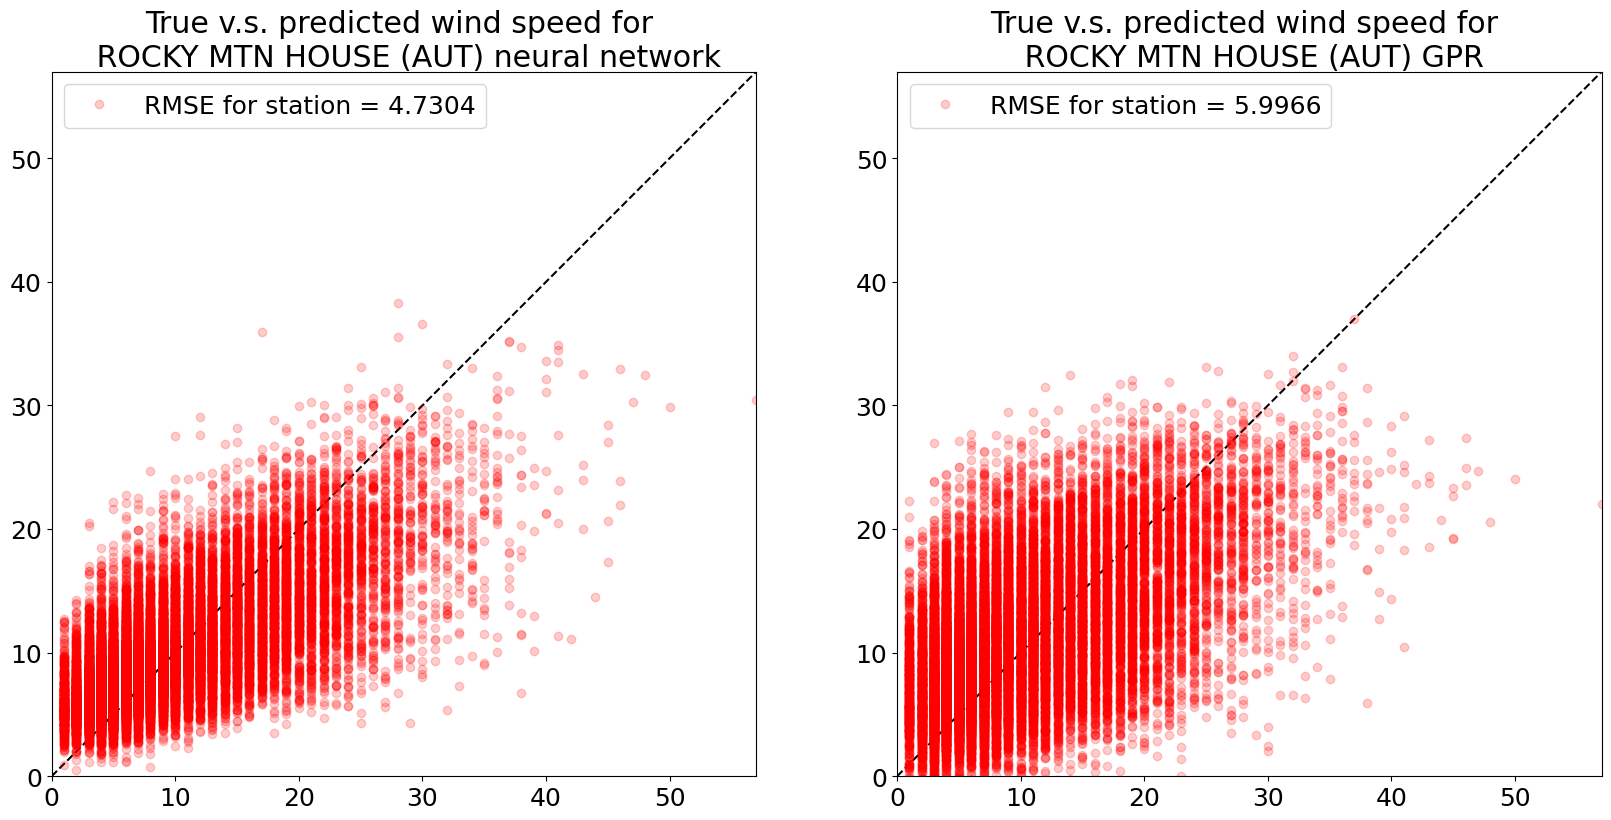

835/835 [==============================] - 1s 655us/step
Root Mean Squared Error: 4.252534007532951


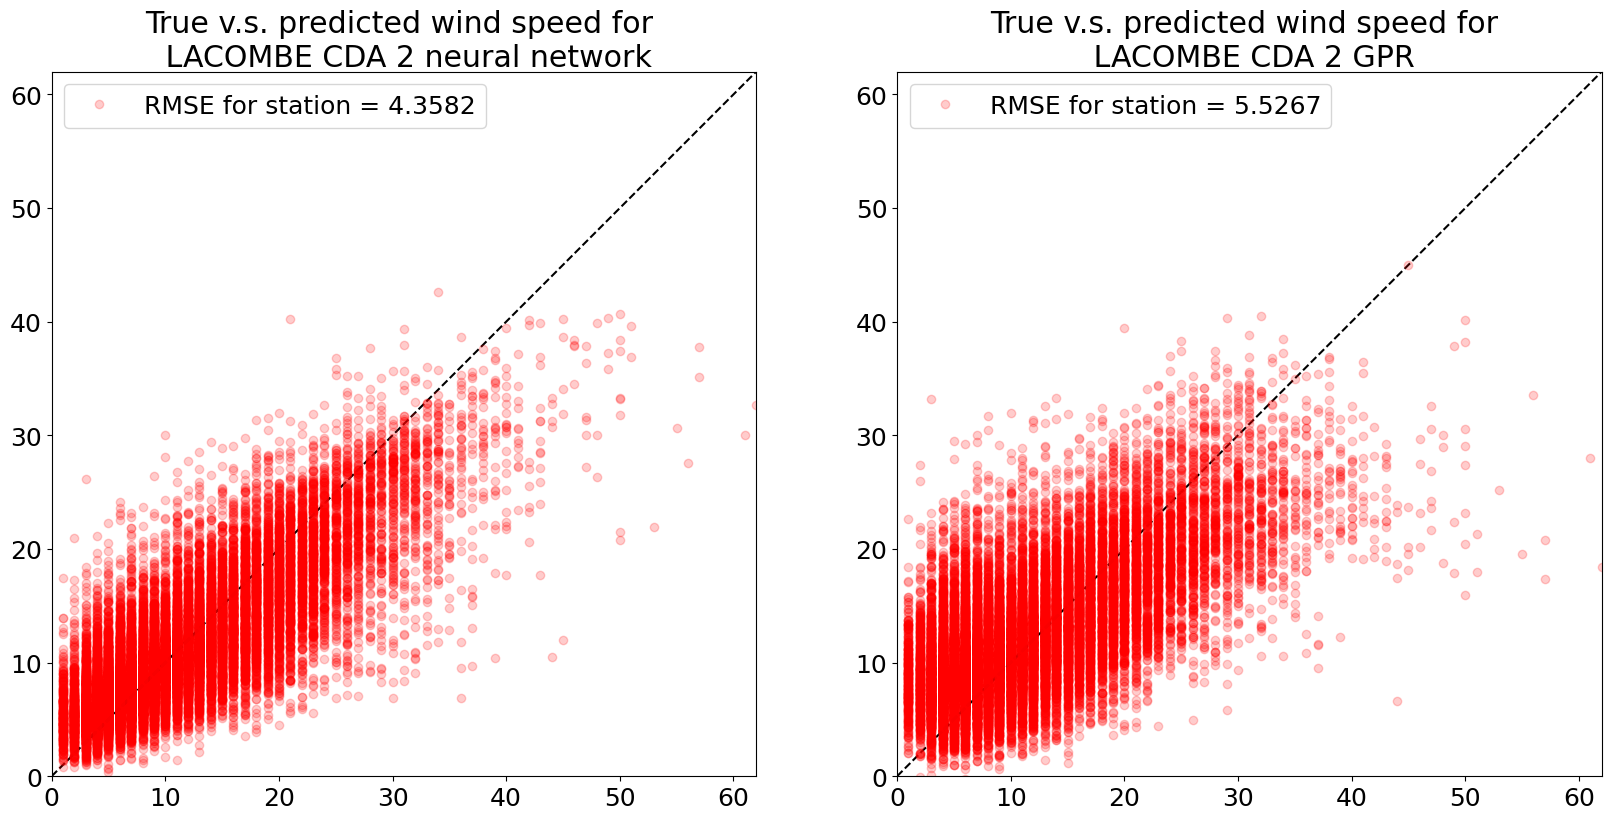

835/835 [==============================] - 1s 719us/step
Root Mean Squared Error: 4.001199649900072


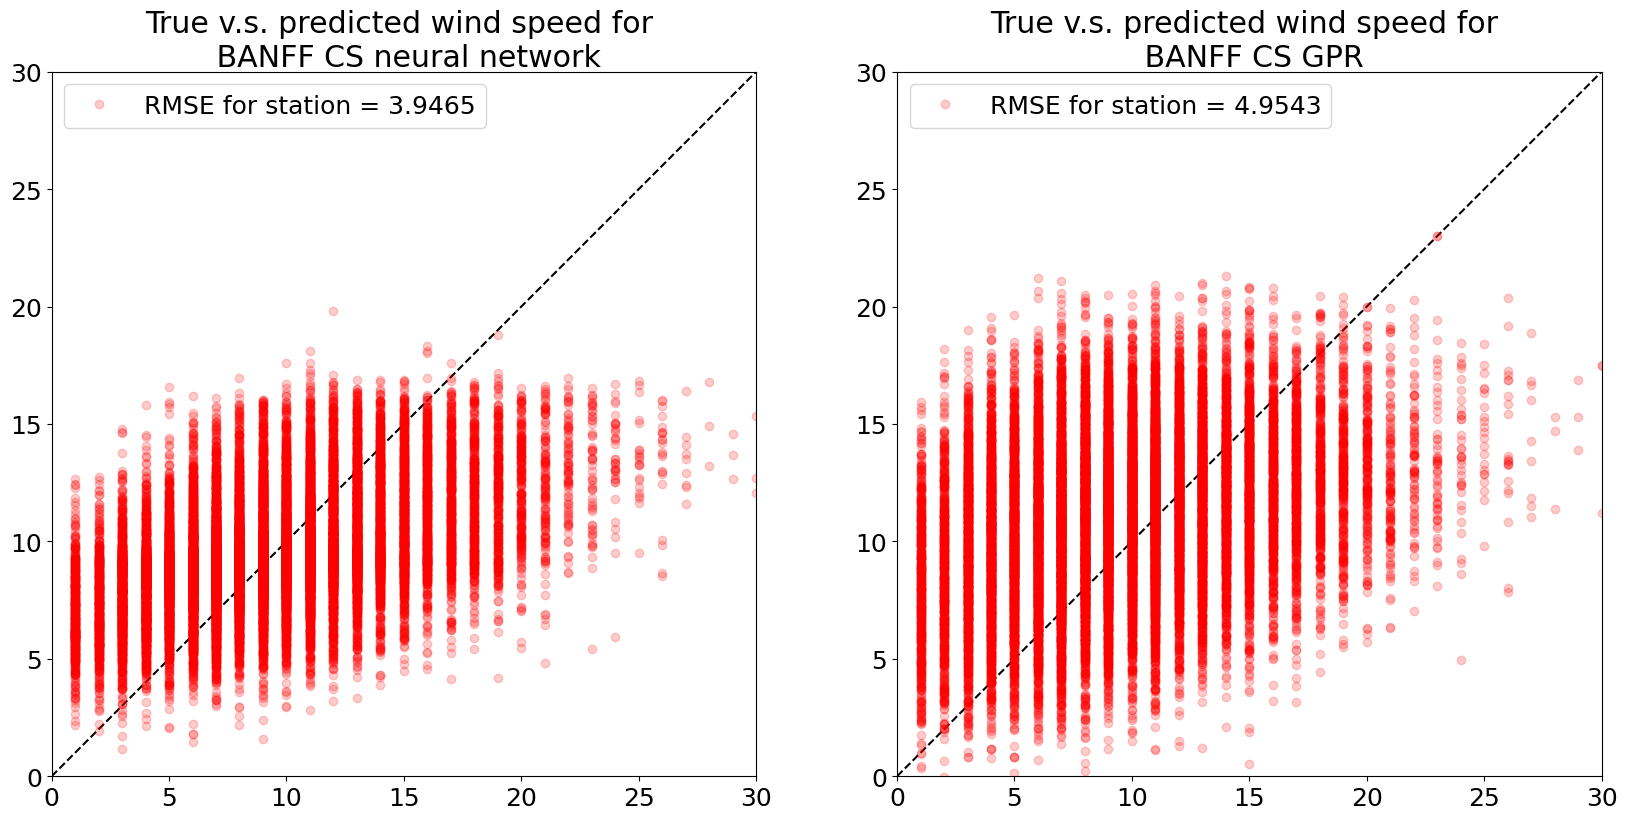

835/835 [==============================] - 1s 699us/step
Root Mean Squared Error: 4.748262733418451


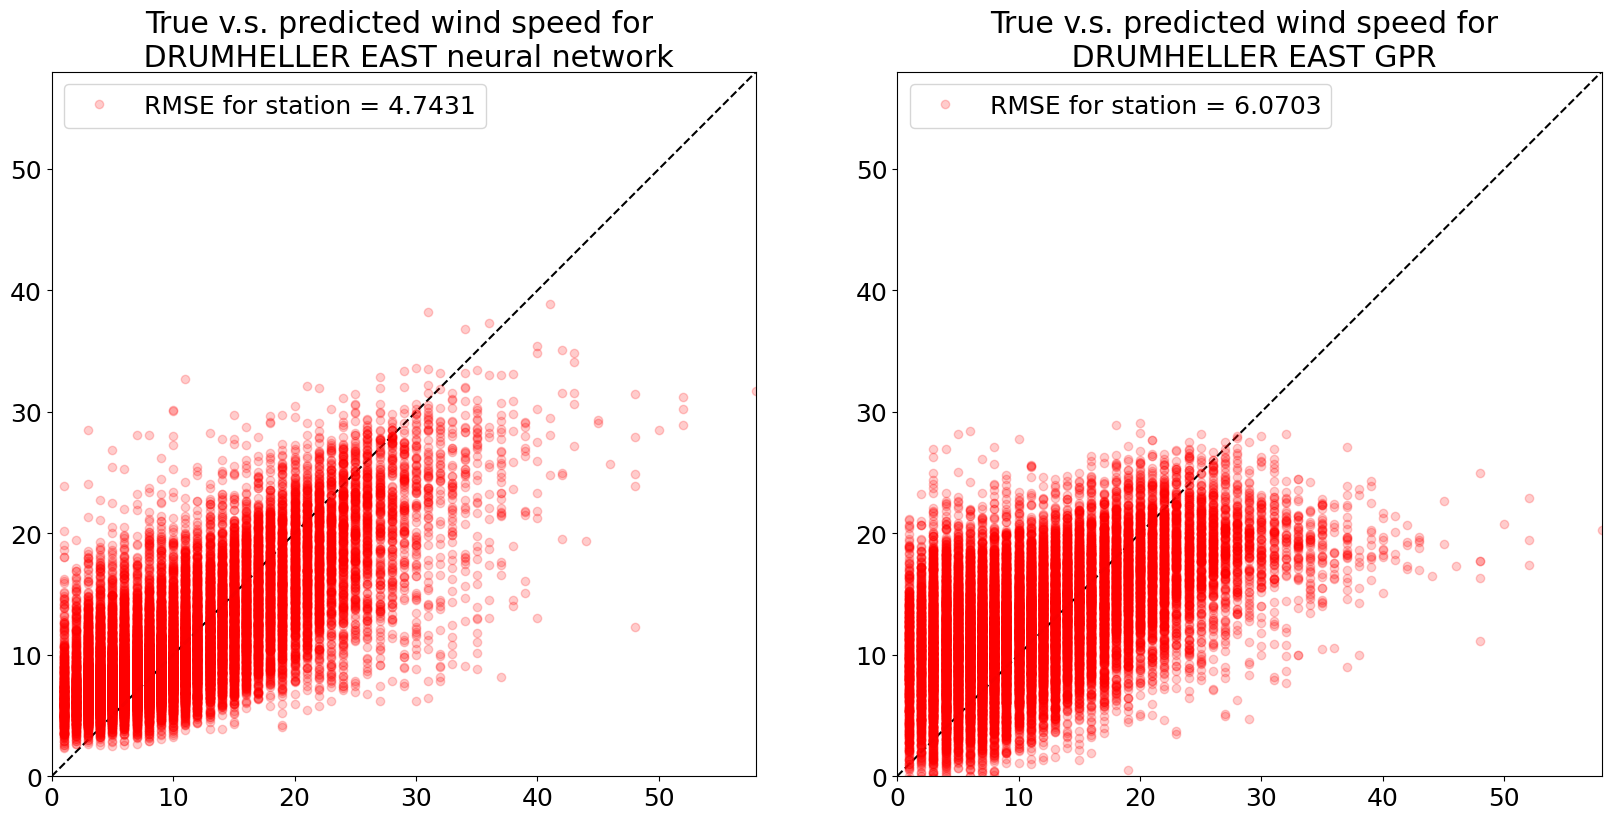

835/835 [==============================] - 1s 679us/step
Root Mean Squared Error: 4.71301113652906


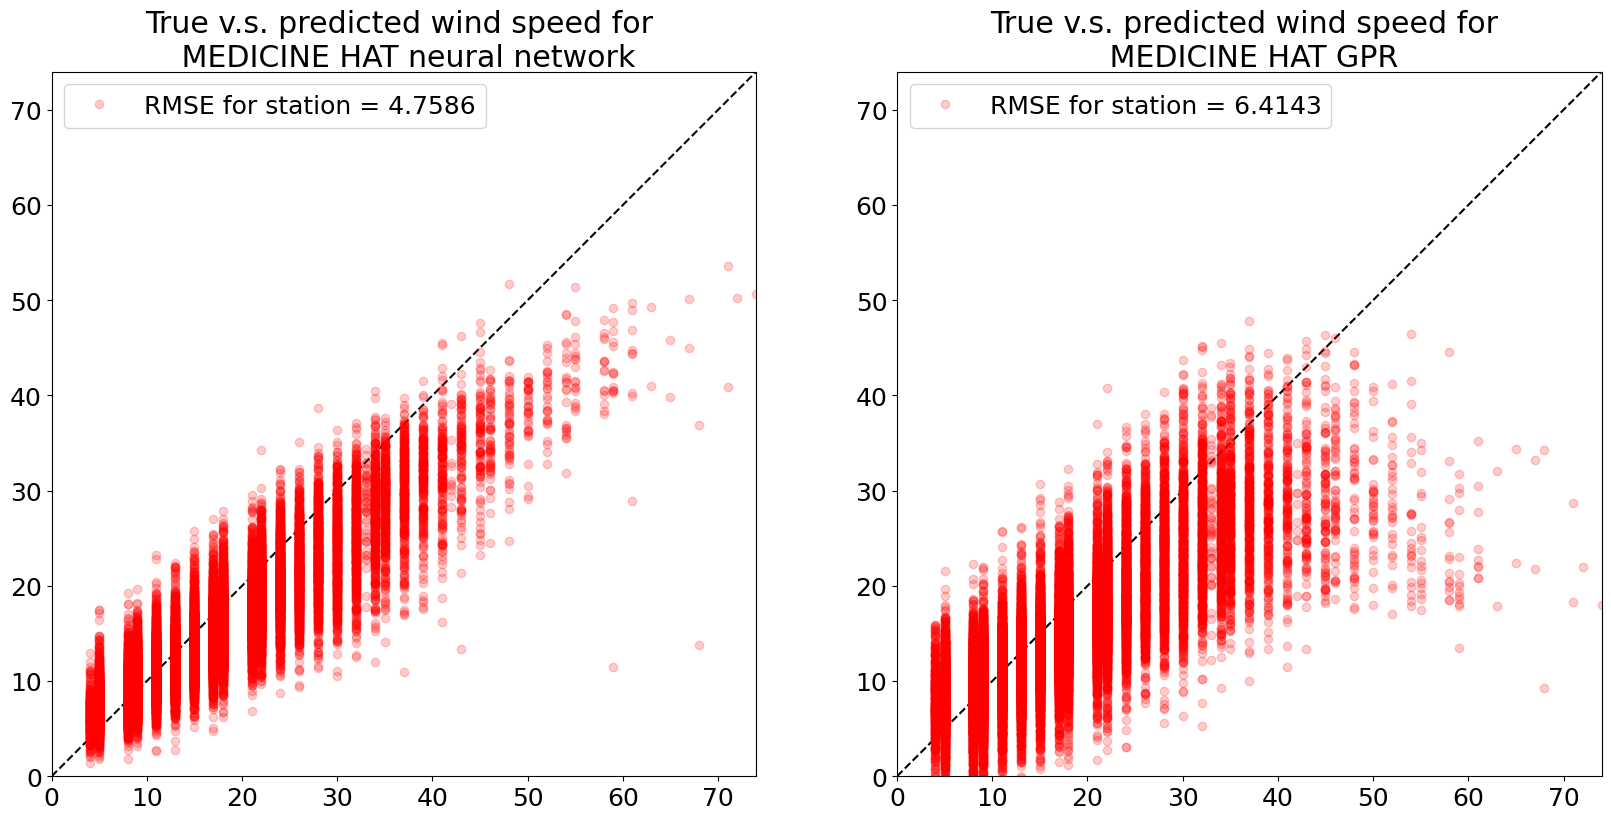

835/835 [==============================] - 1s 803us/step
Root Mean Squared Error: 6.740068651702502


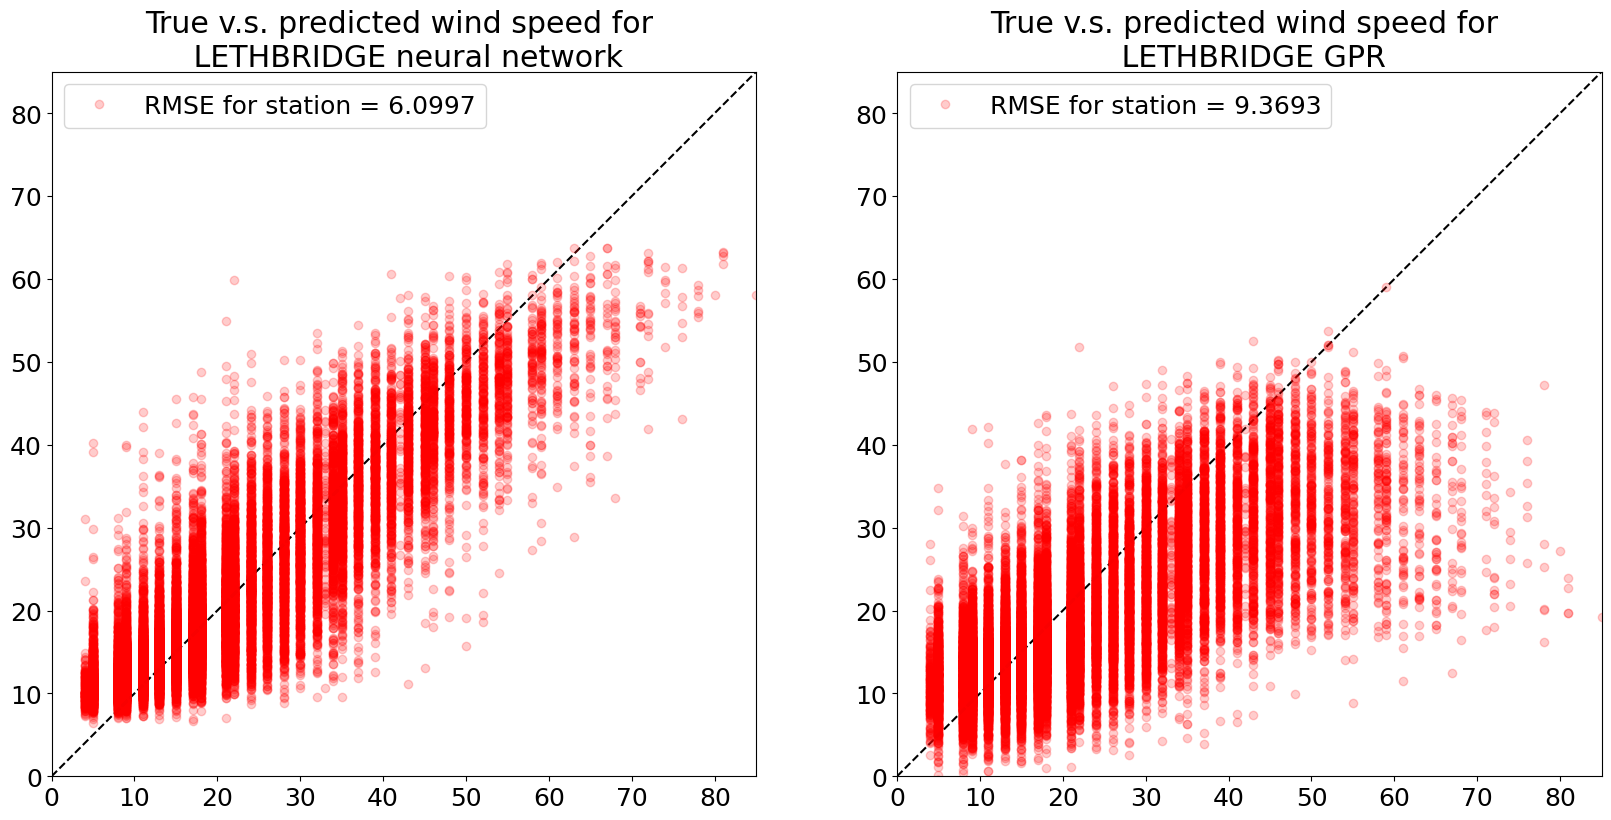

835/835 [==============================] - 1s 743us/step
Root Mean Squared Error: 4.505247510816967


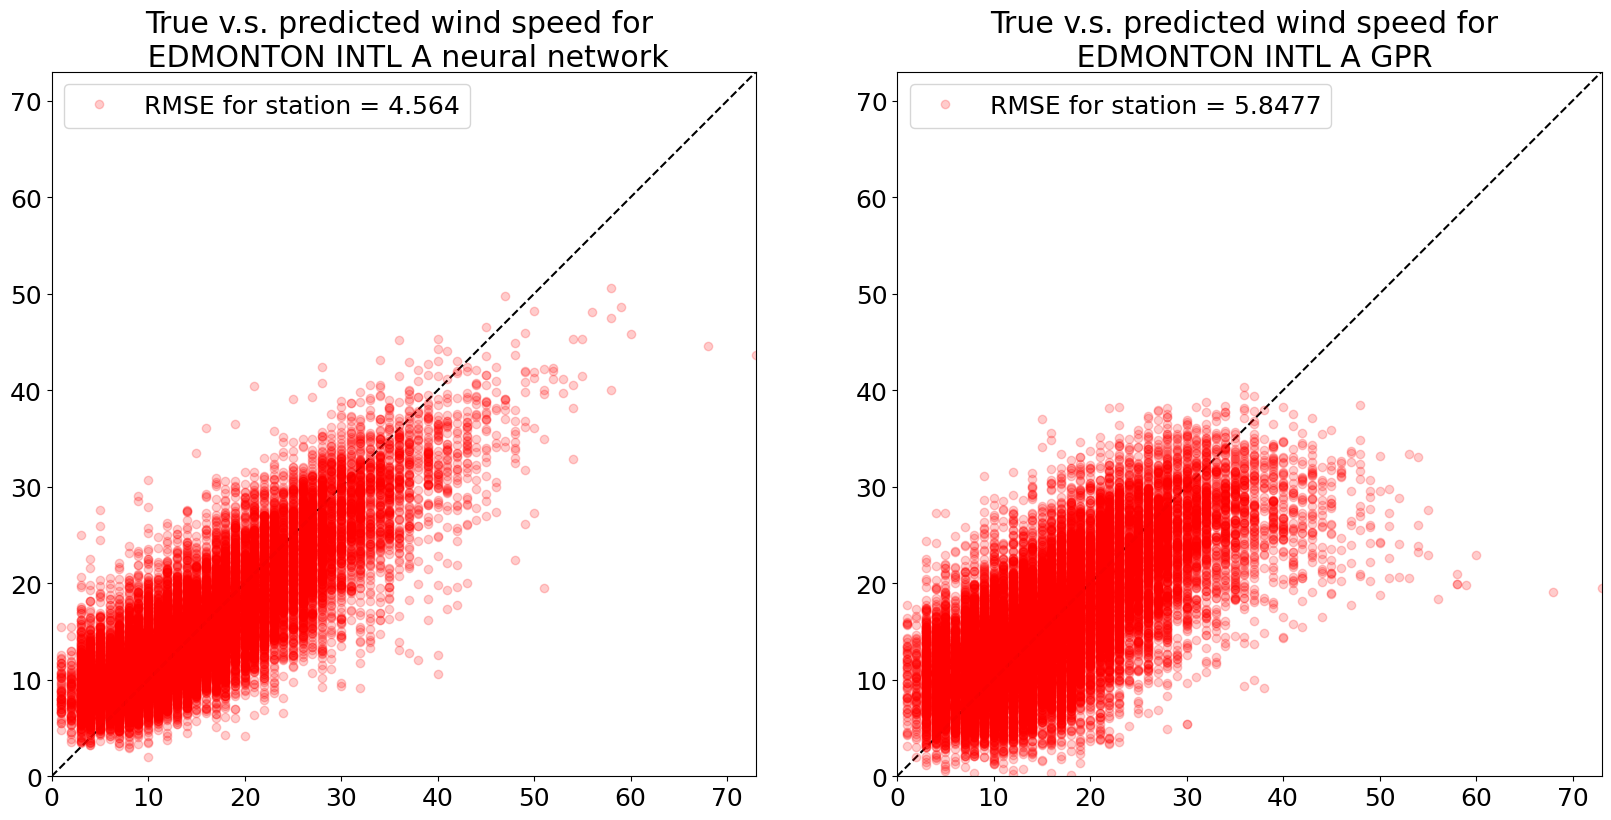

835/835 [==============================] - 1s 905us/step
Root Mean Squared Error: 6.197186794370812


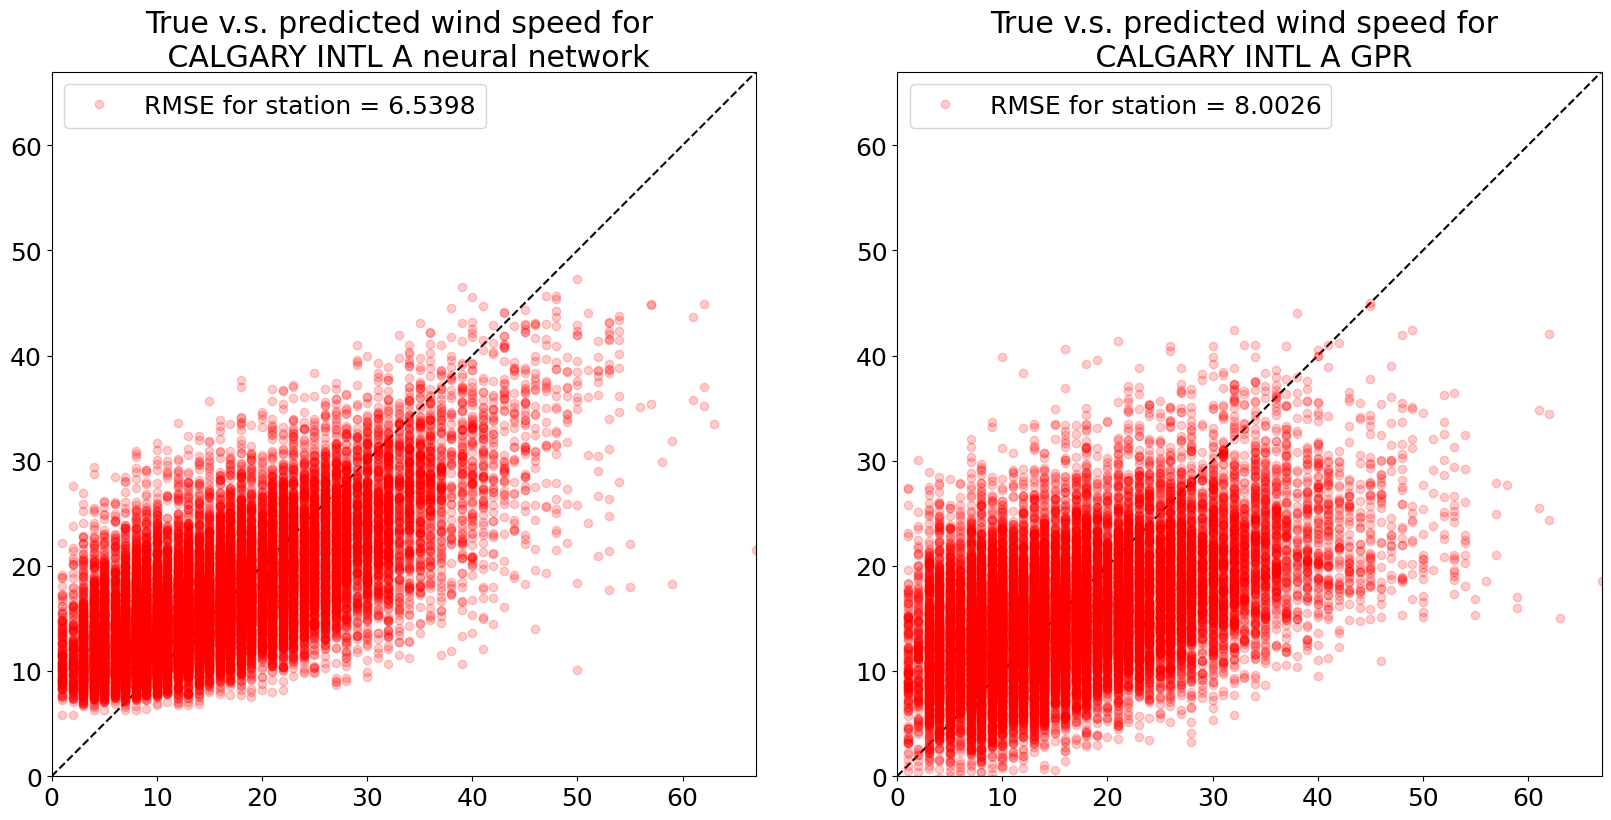

In [ ]:
# plots for testing data
test_x = []
test_y = []

for station in stations_to_test:
    # x is already normalized
    x = pd.read_csv(f'Data/visualization_data/{station}_x.csv', index_col=0).to_numpy()
    y = pd.read_csv(f'Data/visualization_data/{station}_y.csv', index_col=0)['0'].to_numpy().reshape(-1, 1)
    
    nn_prediction = np.array(neural_network_model.predict(x)).flatten()

    gpr_prediction_means,_ = gpr_mdoel.predict(x, y)
    gpr_prediction = []
    for gpr_prediction_means_i in gpr_prediction_means:
        gpr_prediction = np.concatenate((gpr_prediction, gpr_prediction_means_i))

    plot_side_by_side_prediction_error(y, nn_prediction, gpr_prediction, station)


In [195]:
# generate a grid of points for visualization
def generate_grid_points():
    longitude = np.linspace(-110.07, -115.55, 10)
    latitude = np.linspace(49.12, 53.55, 10)
    xx, yy = np.meshgrid(latitude, longitude)
    return np.array(list(zip(xx.flatten(), yy.flatten())))

In [196]:
grid_coor = generate_grid_points()

In [199]:
def find_clostest_n_neighbours(target, unique_stations, number_of_neighbours):
    station_with_locations = unique_stations.copy()

    distances = station_with_locations.apply(
        lambda row: distance.distance(
            [row['latitude'], row['longitude']], [target[0], target[1]]).km,
        axis=1
    )
    station_with_locations['distance'] = distances

    station_in_range = station_with_locations.loc[(station_with_locations['distance'] >= 0)
                                                  & (station_with_locations['distance'] <= 99999)]

    station_to_use = station_in_range.nsmallest(number_of_neighbours, 'distance')
    
    return station_to_use


def extract_data(features, target_coor, features_to_use=None, target_features_to_use=None):
    if features_to_use is None:
        features_to_use = ['latitude', 'longitude', 'temp', 'wind_direction', 'wind_speed']
    if target_features_to_use is None:
        target_features_to_use = ['wind_speed']

    distances = features.apply(
        lambda row: distance.distance(
            [row['latitude'], row['longitude']], [target_coor[0], target_coor[1]]).km,
        axis=1
    )

    processed_features = features.loc[:,features_to_use].copy()
    processed_features['distance'] = distances

    processed_features = processed_features.to_numpy()

    return processed_features


# Note some station will have less data, so the smallest date range is used to mach all stations
def extract_data_match_date_range(features, target_coor, neighbour_station_names):
    processed_features = []

    for name in neighbour_station_names:
        selected_station_data = features.loc[features['name'] == name]
        extracted_features = extract_data(selected_station_data, target_coor)
        if len(processed_features) == 0:
            processed_features = extracted_features
        else:
            processed_features = np.concatenate((processed_features, extracted_features), axis=1)

    return processed_features    

# Given the target station name, find the nearest neighbours within the distance
def generate_data(raw_data, target_coor, number_of_neighbours):

    target_latitude = target_coor[0]
    target_longitude = target_coor[1]

    # select all unique names and coordinates
    unique_stations = raw_data.groupby('name').head(1)

    neighbour_stations = find_clostest_n_neighbours([target_latitude, target_longitude], unique_stations, number_of_neighbours)

    # find k nearest neighbours
    neighbour_station_names = neighbour_stations['name']

    # filter the data, return
    features = raw_data[raw_data['name'].isin(neighbour_station_names)]
    features = extract_data_match_date_range(features, target_coor, neighbour_station_names)

    return features


In [200]:
grid_df = pd.read_csv('Data/processed_ab_no_precp_train.txt')
latest_one_month_records = grid_df.sort_values('date', ascending=False).head(20*300)


C:\Users\PPL\AppData\Local\Temp\ipykernel_87960\2452982092.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  grid_df = pd.read_csv('Data/processed_ab_no_precp_train.txt')


In [251]:
nn_grid_predicitions = []
gpr_grid_predicitions = []
linear_grid_predicitions = []
test_scaler = StandardScaler()

grid_input_data = []

for coor in grid_coor:
    input_feature = generate_data(latest_one_month_records, coor, 9)
    #input_feature = scaler.transform(input_feature)
    if len(grid_input_data) == 0:
        grid_input_data = input_feature
    else:
        grid_input_data = np.concatenate((grid_input_data, input_feature), axis=0)

grid_input_data_scaled = test_scaler.fit_transform(grid_input_data)

938/938 [==============================] - 1s 658us/step


In [275]:
# Model predicitons
nn_prediction = neural_network_model.predict(grid_input_data_scaled)

# y here is just for syntax, not used
gpr_prediction_means,_ = gpr_mdoel.predict(grid_input_data_scaled, np.random.rand(grid_input_data.shape[0],1))
gpr_prediction = []
for gpr_prediction_means_i in gpr_prediction_means:
    gpr_prediction = np.concatenate((gpr_prediction, gpr_prediction_means_i))

# linear model
linear_prediction = linear_model.predict(grid_input_data_scaled)

938/938 [==============================] - 1s 699us/step
Root Mean Squared Error: 15.335674917083985


In [276]:
np.mean(nn_prediction)

19.02703

In [277]:
nn_grid_predicitions_avg = np.mean(nn_prediction.reshape(10,10,300), axis=2)
gpr_grid_predicitions_avg = np.mean(gpr_prediction.reshape(10,10,300), axis=2)
linear_grid_predicitions_avg = np.mean(linear_prediction.reshape(10,10,300), axis=2)

<a list of 31 text.Text objects>

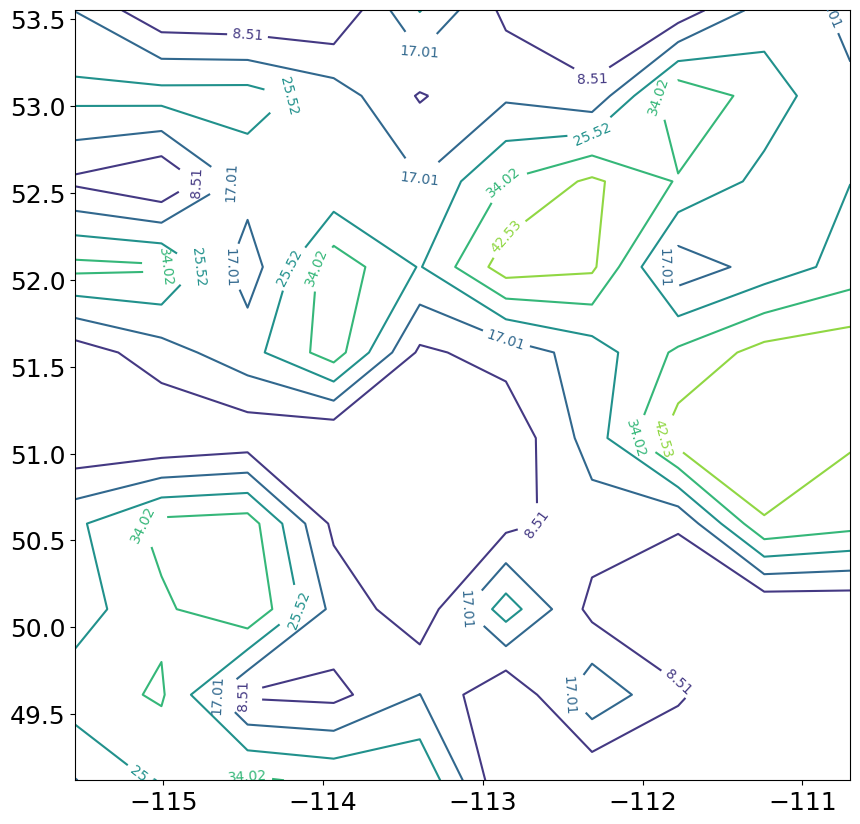

In [278]:
levels = np.linspace(np.min(nn_grid_predicitions_avg), np.max(nn_grid_predicitions_avg), 7)

longitude = np.linspace(-110.7, -115.55, 10)
latitude = np.linspace(49.12, 53.55, 10)
xx, yy = np.meshgrid(latitude, longitude)

z = nn_grid_predicitions_avg

fig, ax = plt.subplots(figsize=(10,10))
cs = ax.contour(yy, xx, z, levels=levels)
ax.clabel(cs, inline=True, fontsize=10)

<a list of 17 text.Text objects>

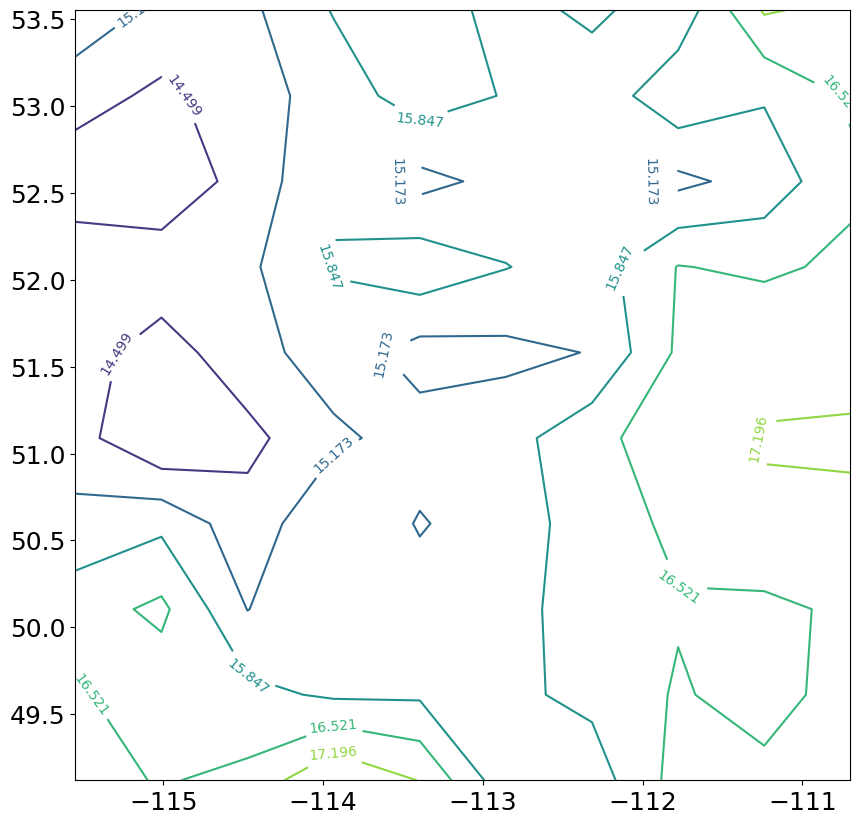

In [279]:
levels = np.linspace(np.min(gpr_grid_predicitions_avg), np.max(gpr_grid_predicitions_avg), 7)

longitude = np.linspace(-110.7, -115.55, 10)
latitude = np.linspace(49.12, 53.55, 10)
xx, yy = np.meshgrid(latitude, longitude)

z = gpr_grid_predicitions_avg

fig, ax = plt.subplots(figsize=(10,10))
cs = ax.contour(yy, xx, z, levels=levels)
ax.clabel(cs, inline=True, fontsize=10)

<a list of 13 text.Text objects>

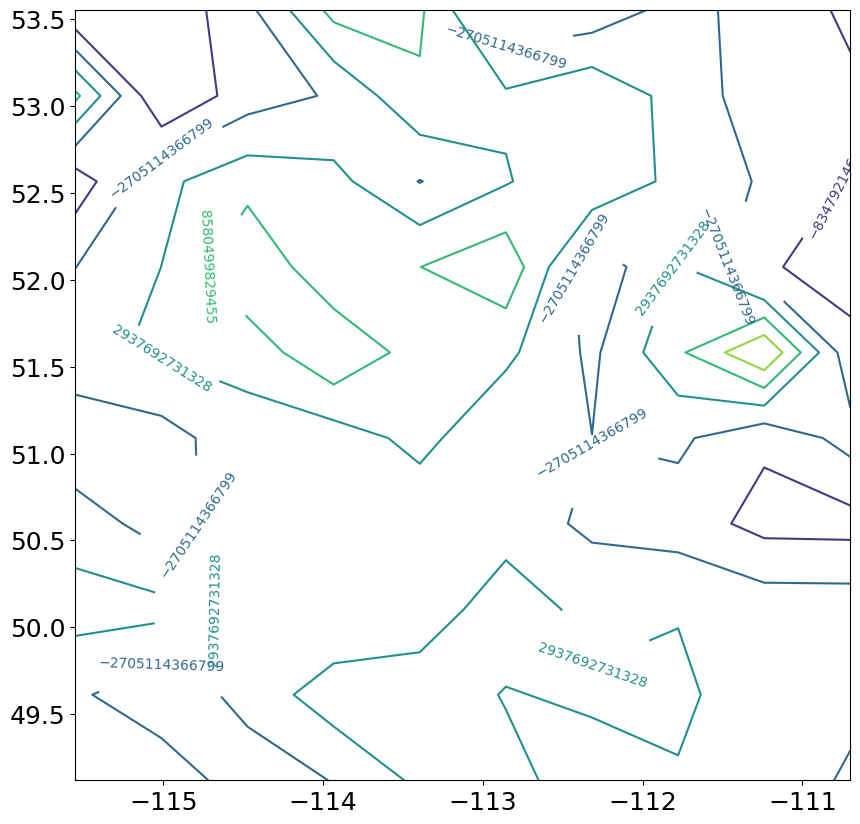

In [280]:
levels = np.linspace(np.min(linear_grid_predicitions_avg), np.max(linear_grid_predicitions_avg), 7)

longitude = np.linspace(-110.7, -115.55, 10)
latitude = np.linspace(49.12, 53.55, 10)
xx, yy = np.meshgrid(latitude, longitude)

z = linear_grid_predicitions_avg

fig, ax = plt.subplots(figsize=(10,10))
cs = ax.contour(yy, xx, z, levels=levels)
ax.clabel(cs, inline=True, fontsize=10)